In [1]:
import copy
import iminuit as iminuit
import numba
import optuna
import pandas as pd
from catboost import CatBoostRegressor, CatBoostClassifier
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, StratifiedKFold

from model import LightningFullyConnected, BigLightningModel, FullyConnectedModel
from verstack import LGBMTuner
from lightgbm import LGBMClassifier
import lightning as L
import numpy as np
import pandas as pd
from dataset import ParticleDataset
import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
import pickle
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, log_loss

2023-05-21 09:21:24.151884: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 09:21:25.659587: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-21 09:21:25.659719: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-21 09:21:25.659732: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
hidden_channels = 20
decode_channels = 6
hidden_layers = 5
p_dropout = 0.2
lr = 0.0003
activation=nn.LeakyReLU
final_activation=nn.Sigmoid
batch_size=2500
optimizer=optim.AdamW
scheduler=optim.lr_scheduler.CosineAnnealingLR
loss_fn=F.binary_cross_entropy
in_channels=15
out_channels=1
use_wandb=True

model1: LightningFullyConnected = LightningFullyConnected.load_from_checkpoint("../data/initial/model1_opt.ckpt")

model1_en: FullyConnectedModel = FullyConnectedModel(in_channels, out_channels, hidden_channels, decode_channels, hidden_layers, p_dropout, activation, final_activation)
model1_en.load_state_dict(torch.load("../data/initial/model_en.pth"))
model1_en.to("cpu")
model1_en.eval()

model_big: LightningFullyConnected = BigLightningModel.load_from_checkpoint("../data/initial/modelbig1.ckpt")

model1.to("cpu")
model_big.to("cpu")

model1.eval()
model_big.eval()

with open("../data/initial/lgbm_tuner.pickle", "rb") as f:
    tuner: LGBMTuner = pickle.load(f)

all_train = ParticleDataset()

data1_train, data1_val = ParticleDataset().split_data(0.8, seed=42)
data2_train, data2_val = ParticleDataset(target="ALL").split_data(0.8, seed=42)

data1_val[:][0].to("cpu")
data2_val[:][0].to("cpu")
data1_train[:][0].to("cpu")
data2_train[:][0].to("cpu")
data1_val[:][1].to("cpu")
data2_val[:][1].to("cpu")
data1_train[:][1].to("cpu")
data2_train[:][1].to("cpu")


print(data1_train[:][0].shape, data1_train[:][1].shape)
print(data2_train[:][0].shape, data2_train[:][1].shape)

torch.Size([130000, 15]) torch.Size([130000])
torch.Size([130000, 15]) torch.Size([130000, 160])


In [3]:
nn_proba = model1(data1_val[:][0]).detach().numpy().reshape(-1)
print(nn_proba)
print(data1_val[:][1].detach().numpy())
print(np.mean(np.round(nn_proba) == data1_val[:][1].detach().numpy()))

[0.95635647 0.99430954 0.9378454  ... 0.0034794  0.99952865 0.99459416]
[1. 1. 1. ... 0. 1. 1.]
0.9301846153846154


In [4]:
lgbmtuner = LGBMTuner(metric="log_loss", trials=200)
lgbmtuner.fit(pd.DataFrame(data1_train[:][0].detach().numpy(), columns=all_train.variables),
              pd.Series(data1_train[:][1].detach().numpy()))


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 200 trials
     .. Evaluation metric: log_loss 
     .. Study direction: minimize log_loss




KeyboardInterrupt



In [5]:
lgbm_hyper = {'task': 'train', 'learning_rate': 0.04, 'num_leaves': 158, 'feature_fraction': 0.7758858169778262, 'bagging_fraction': 0.6447189399303701, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'lambda_l1': 6.846114915590905, 'lambda_l2': 1.8801187817986014, 'min_split_gain': 0.0, 'zero_as_missing': False, 'max_bin': 255, 'min_data_in_bin': 3, 'random_state': 42, 'device_type': 'cpu', 'num_classes': 1, 'objective': 'binary', 'metric': 'binary_logloss', 'num_threads': 6, 'min_sum_hessian_in_leaf': 1.016024682289675, 'num_iterations': 519}

data_train_big = model_big(data1_train[:][0])
print(data_train_big.shape)
data_train_big = data_train_big.detach().numpy()

data_val_big = model_big(data1_val[:][0])
data_val_big = data_val_big.detach().numpy()
print(data_train_big.shape)

lgbm = LGBMClassifier(**lgbm_hyper)
lgbm_big = LGBMClassifier(**lgbm_hyper)
lgbm.fit(data1_train[:][0].numpy(), data1_train[:][1].numpy())
lgbm_big.fit(data_train_big, data1_train[:][1])

nn_proba = model1(data1_val[:][0]).detach().numpy().reshape(-1)
nn_en_proba = model1_en(data1_val[:][0]).detach().numpy().reshape(-1)

nn_big_values = model_big(data1_val[:][0])
nn_big_values = nn_big_values.detach().numpy()

lgbm_score = lgbm.score(data1_val[:][0].numpy(), data1_val[:][1].numpy())
lgbm_big_score = lgbm_big.score(nn_big_values, data1_val[:][1].numpy())

lgbm_proba = lgbm.predict_proba(data1_val[:][0].numpy())[:, 1]
lgbm_big_proba = lgbm_big.predict_proba(nn_big_values)[:, 1]


print(lgbm_score)
print(lgbm_big_score)

torch.Size([130000, 160])
(130000, 160)
0.9378461538461539
0.9268923076923077


In [17]:
def objective(trial: optuna.Trial, feature_values, target_values, n_splits=5) -> float:
    params = {
        "iterations": trial.suggest_int("iterations", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Poisson"]),
        "random_strength": trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 10.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "verbose": False,
        "task_type": "GPU",
        "loss_function": "Logloss",
        "eval_metric": "Logloss"
    }
    cat_clf = CatBoostClassifier(**params)
    total_log_loss = 0.
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_index, val_index in skf.split(feature_values, target_values):
        X_train = feature_values[train_index]
        X_val = feature_values[val_index]
        y_train = target_values[train_index]
        y_val = target_values[val_index]
        cat_clf.fit(X_train, y_train)
        total_log_loss += log_loss(y_val, cat_clf.predict_proba(X_val))
    return total_log_loss / n_splits

study = optuna.create_study(direction="minimize")
optuna.logging.set_verbosity(optuna.logging.INFO)
study.optimize(lambda t: objective(t, data1_train[:][0].detach().numpy(), data1_train[:][1].detach().numpy()), n_trials=200)

[I 2023-05-20 10:14:19,692] A new study created in memory with name: no-name-ce7df431-835c-42dc-821a-9de7d39a6f43
[I 2023-05-20 10:14:52,969] Trial 0 finished with value: 0.25020443487752175 and parameters: {'iterations': 1017, 'learning_rate': 0.001434658622232811, 'depth': 5, 'l2_leaf_reg': 0.574286314479055, 'bootstrap_type': 'Bayesian', 'random_strength': 2.4335926369710308e-05, 'bagging_temperature': 5.76096320282984, 'od_type': 'Iter', 'od_wait': 36}. Best is trial 0 with value: 0.25020443487752175.
[I 2023-05-20 10:15:39,787] Trial 1 finished with value: 0.17484356858721378 and parameters: {'iterations': 729, 'learning_rate': 0.04912077535867158, 'depth': 9, 'l2_leaf_reg': 2.7052296921828024e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0006504661072692851, 'bagging_temperature': 0.4758558814908942, 'od_type': 'IncToDec', 'od_wait': 22}. Best is trial 1 with value: 0.17484356858721378.
[I 2023-05-20 10:16:29,358] Trial 2 finished with value: 0.17737173729858263 and par

In [6]:
best_params = {'iterations': 2000, 'learning_rate': 0.03254880658174435, 'depth': 7, 'l2_leaf_reg': 7.565788405198633, 'bootstrap_type': 'Bayesian', 'random_strength': 4.118449381050315e-06, 'bagging_temperature': 0.36985835084484797, 'od_type': 'Iter', 'od_wait': 40}

cat_clf = CatBoostClassifier(verbose=False,
                             task_type="GPU",
                             loss_function="Logloss",
                             eval_metric="Logloss",
                             **best_params,)
import pickle

with open("/home/amh/Documents/Coding/GitHub/AppliedML2023/data/initial/cat_clf1.pkl", "wb") as f:
    pickle.dump(cat_clf, f)

cat_clf.fit(data1_train[:][0].numpy(), data1_train[:][1].numpy())
cat_proba = cat_clf.predict_proba(data1_val[:][0].numpy())[:, 1]

In [7]:
val_target = data1_val[:][1].detach().numpy()
w1 = np.mean(lgbm.predict(data1_train[:][0].numpy()) == data1_train[:][1].numpy())
w2 = np.mean(cat_clf.predict(data1_train[:][0].numpy()) == data1_train[:][1].numpy())
w3 = np.mean(np.round(model1_en(data1_train[:][0]).detach().numpy().reshape(-1)) == data1_train[:][1].numpy())
w4 = np.mean(lgbm_big.predict(data_train_big) == data1_train[:][1].numpy())

print(f"lgbm acc: {(lgbm_acc := np.mean(np.round(lgbm_proba) == val_target))}")
print(f"nn acc: {(nn_acc := np.mean(np.round(nn_proba) == val_target))}")
print(f"nn_en acc: {(nn_en_acc := np.mean(np.round(nn_en_proba) == val_target))}")
print(f"cat acc: {(cat_acc := np.mean(np.round(cat_proba) == val_target))}")
print(f"lgbm big acc: {(lgbm_big_acc := np.mean(np.round(lgbm_big_proba) == val_target))}")
ensemble_proba = ((w1 * lgbm_proba + w2 * cat_proba + w3 * nn_proba)
                  / (w1 + w2 + w3))
ensemble_proba1 = ((w1 * lgbm_proba + w2 * cat_proba)
                  / (w1 + w2))
print(w1, w2, w3, w4)

print(f"ensemble: {np.mean(np.round(ensemble_proba) == val_target)}")
print(f"ensemble: {np.mean(np.round(ensemble_proba1) == val_target)}")

lgbm acc: 0.9378461538461539
nn acc: 0.9301846153846154
nn_en acc: 0.9278153846153846
cat acc: 0.9387692307692308
lgbm big acc: 0.9268923076923077
0.9644230769230769 0.9607307692307693 0.9292307692307692 0.9668923076923077
ensemble: 0.9385846153846154
ensemble: 0.9386769230769231


In [8]:
@numba.njit()
def get_acc(proba, val):
    return np.mean(np.round(proba) == val)

print(f"lgbm acc: {(lgbm_acc := np.mean(np.round(lgbm_proba) == val_target))}")
print(f"nn acc: {(nn_acc := np.mean(np.round(nn_proba) == val_target))}")
print(f"nn_en acc: {(nn_en_acc := np.mean(np.round(nn_en_proba) == val_target))}")
print(f"cat acc: {(cat_acc := np.mean(np.round(cat_proba) == val_target))}")
print(f"lgbm big acc: {(lgbm_big_acc := np.mean(np.round(lgbm_big_proba) == val_target))}")

# Average Ensemble
ensemble_proba_avg2 = (lgbm_proba + cat_proba) / 2
ensemble_proba_avg3 = (lgbm_proba + cat_proba + nn_proba) / 3
ensemble_proba_avg4 = (lgbm_proba + cat_proba + nn_proba + lgbm_big_proba) / 4
print(f"{get_acc(ensemble_proba_avg3, val_target)=}")
print(f"{get_acc(ensemble_proba_avg4, val_target)=}")

# Weighted Ensembles
# 4 models
ensemble_proba_w4 = ((w1 * lgbm_proba + w2 * cat_proba + w3 * nn_proba + w4 * lgbm_big_proba)
                     / (w1 + w2 + w3 + w4))

# 3 models
ensemble_proba_w3 = ((w1 * lgbm_proba + w2 * cat_proba + w3 * nn_proba)
                     / (w1 + w2 + w3))


# 2 models
ensemble_proba_w2 = ((w1 * lgbm_proba + w2 * cat_proba)
                     / (w1 + w2))

print(f"{get_acc(ensemble_proba_w2, val_target)=}")
print(f"{get_acc(ensemble_proba_w3, val_target)=}")
print(f"{get_acc(ensemble_proba_w4, val_target)=}")

@numba.njit(parallel=True)
def construct_greedy_ensemble(proba1=lgbm.predict_proba(data1_train[:][0].numpy())[:, 1],
                              proba2=cat_clf.predict_proba(data1_train[:][0].numpy())[:, 1],
                              proba3=model1_en(data1_train[:][0]).detach().numpy().reshape(-1),
                              number_of_fracs=(10, 10, 10),
                              train_target=data1_train[:][1].numpy(),
                              val_target=data1_val[:][1].numpy(),):
    train_acc = np.empty(number_of_fracs, dtype=np.float32)
    val_acc = np.empty(number_of_fracs, dtype=np.float32)

    f1_range = np.linspace(0.001, 1, number_of_fracs[0])
    f2_range = np.linspace(0.001, 1, number_of_fracs[1])
    f3_range = np.linspace(0.001, 1, number_of_fracs[2])

    for i in range(number_of_fracs[0]):
        print(i)
        f1 = f1_range[i]
        for j in range(number_of_fracs[1]):
            f2 = f2_range[j]
            for k in range(number_of_fracs[2]):
                f3 = f3_range[k]
                train_acc[i, j, k] = get_acc((f1 * proba1 + f2 * proba2 + f3 * proba3) / (f1 + f2 + f3),
                                             train_target
                )
                val_acc[i, j, k] = get_acc(
                    (f1 * lgbm_proba + f2 * cat_proba + f3 * nn_proba) / (f1 + f2 + f3),
                    val_target
                )
    return train_acc, val_acc

# # Greedy ensemble  - Doesn't work LGBM too over fitted
# train_acc, val_acc = construct_greedy_ensemble()
# fracs1 = np.linspace(0.1, 1, 10)
# fracs2 = np.linspace(0.1, 1, 10)
# fracs3 = np.linspace(0.1, 1, 10)
# scores = []
# for i, f1 in enumerate(fracs1):
#     for j, f2 in enumerate(fracs2):
#         for k, f3 in enumerate(fracs3):
#             scores.append((train_acc[i, j, k], val_acc[i, j, k], (f1, f2, f3)))
# print(sorted(scores[::-1][:15]))

# # bdt-ensemble  - Way too overfitted :(
# ensemble_cat_clf = copy.deepcopy(cat_clf)
# ensemble_train = np.concatenate([data1_train[:][0].detach().numpy(),
#                                  lgbm.predict_proba(data1_train[:][0].numpy())[:, 1].reshape(-1, 1),
#                                  cat_clf.predict_proba(data1_train[:][0].numpy())[:, 1].reshape(-1, 1),
#                                  model1_en(data1_train[:][0]).detach().numpy().reshape(-1, 1),
#                                  ], axis=1)
# ensemble_val = np.concatenate([data1_val[:][0].detach().numpy(),
#                                lgbm.predict_proba(data1_val[:][0].numpy())[:, 1].reshape(-1, 1),
#                                cat_clf.predict_proba(data1_val[:][0].numpy())[:, 1].reshape(-1, 1),
#                                model1_en(data1_val[:][0]).detach().numpy().reshape(-1, 1),
#                                ], axis=1)
# ensemble_cat_clf.fit(ensemble_train, data1_train[:][1].numpy())
# print(ensemble_cat_clf.score(ensemble_val, data1_val[:][1].numpy()))
# print(ensemble_cat_clf.score(ensemble_train, data1_train[:][1].numpy()))

lgbm acc: 0.9378461538461539
nn acc: 0.9301846153846154
nn_en acc: 0.9278153846153846
cat acc: 0.9387692307692308
lgbm big acc: 0.9268923076923077
get_acc(ensemble_proba_avg3, val_target)=0.9385846153846154
get_acc(ensemble_proba_avg4, val_target)=0.9377230769230769
get_acc(ensemble_proba_w2, val_target)=0.9386769230769231
get_acc(ensemble_proba_w3, val_target)=0.9385846153846154
get_acc(ensemble_proba_w4, val_target)=0.9377230769230769


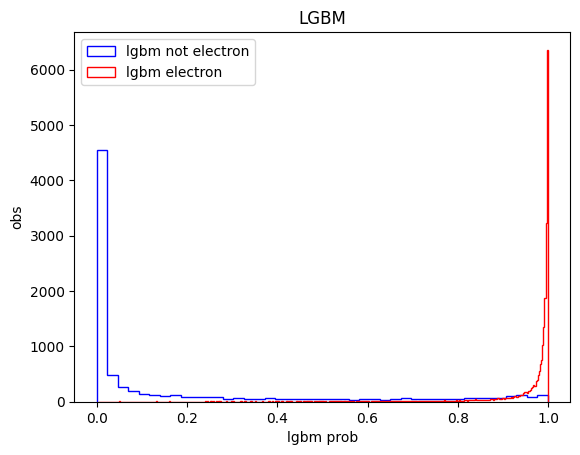

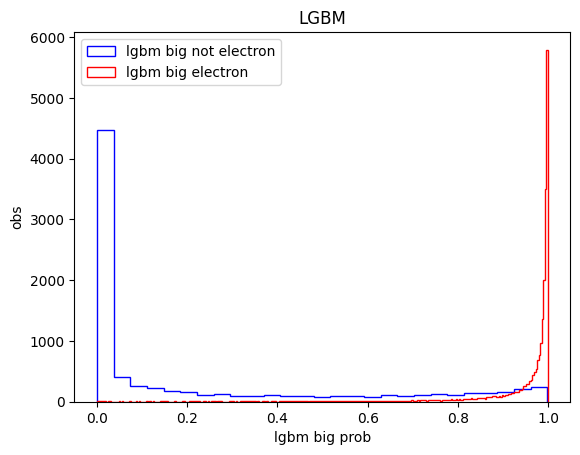

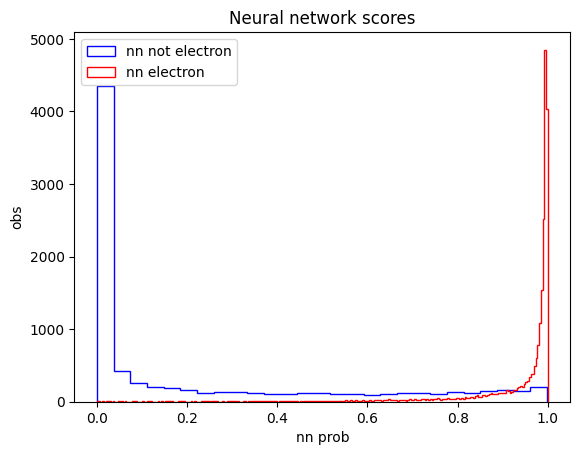

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


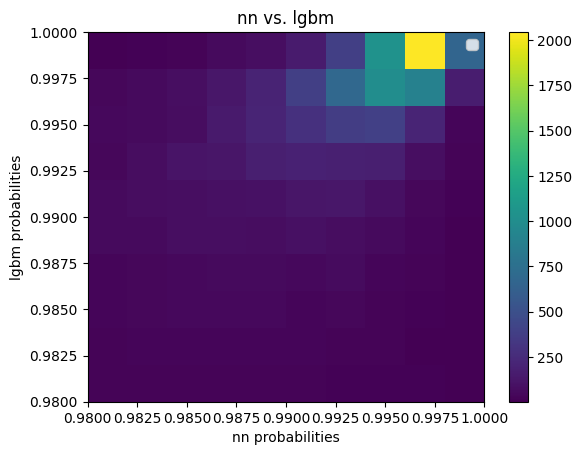

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


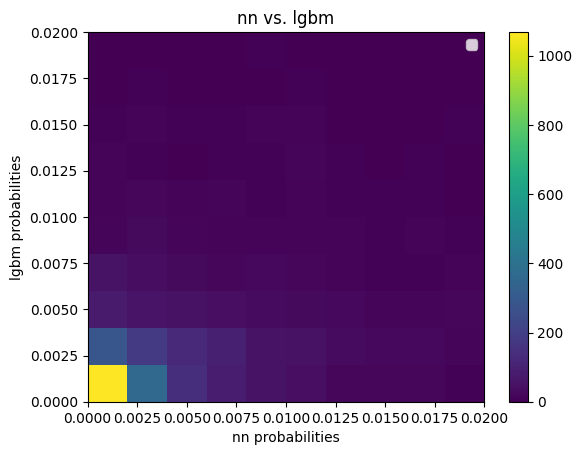

In [21]:

plt.hist(lgbm_proba[val_target == 0], bins="auto", label="lgbm not electron", color="b", histtype="step")
plt.hist(lgbm_proba[val_target == 1], bins="auto", label="lgbm electron", color="r", histtype="step")
plt.xlabel("lgbm prob")
plt.ylabel("obs")
plt.title("LGBM")
plt.legend()
plt.show()

plt.hist(lgbm_big_proba[val_target == 0], bins="auto", label="lgbm big not electron", color="b", histtype="step")
plt.hist(lgbm_big_proba[val_target == 1], bins="auto", label="lgbm big electron", color="r", histtype="step")
plt.xlabel("lgbm big prob")
plt.ylabel("obs")
plt.title("LGBM")
plt.legend()
plt.show()

plt.hist(nn_proba[val_target == 0], bins="auto", label="nn not electron", color="b", histtype="step")
plt.hist(nn_proba[val_target == 1], bins="auto", label="nn electron", color="r", histtype="step")
plt.xlabel("nn prob")
plt.ylabel("obs")
plt.title("Neural network scores")
plt.legend()
plt.show()

plt.hist2d(nn_proba, lgbm_proba, label="all", bins=(10, 10), range=((0.98, 1.0), (0.98, 1.0)))
plt.colorbar()
plt.xlabel("nn probabilities")
plt.ylabel("lgbm probabilities")
plt.title("nn vs. lgbm")
plt.legend()
plt.show()

plt.hist2d(nn_proba, lgbm_proba, label="all", bins=(10, 10), range=((0.0, 0.02), (0.0, 0.02)))
plt.colorbar()
plt.xlabel("nn probabilities")
plt.ylabel("lgbm probabilities")
plt.title("nn vs. lgbm")
plt.legend()
plt.show()


In [30]:
print(np.max(nn_proba))
print(lgbm_proba)
print(cat_proba)

1.0
[0.96523965 0.9965943  0.9581883  ... 0.00495151 0.99756923 0.72882593]
[0.95982631 0.99424189 0.93998391 ... 0.00102499 0.99833765 0.89443262]


In [12]:
from sklearn.metrics import log_loss

In [16]:
print("a2", log_loss(val_target, ensemble_proba_avg2))
print("a3", log_loss(val_target, ensemble_proba_avg3))
print("a4", log_loss(val_target, ensemble_proba_avg4))

print("w2", log_loss(val_target, ensemble_proba_w2))
print("w3", log_loss(val_target, ensemble_proba_w3))
print("w4", log_loss(val_target, ensemble_proba_w4))

print("lgbm", log_loss(val_target, lgbm_proba))
print("cat", log_loss(val_target, cat_proba))
print("nn", F.binary_cross_entropy(model1(data1_val[:][0])[:, 0], data1_val[:][1]))

# Models ranked: a2, w2, cat, w3, a3, lgbm, w4, a4, nn

a2 0.15665813926579952
a3 0.1587697639388772
a4 0.16178342330805986
w2 0.15665955843328
w3 0.15866515405916004
w4 0.16173342804733098
lgbm 0.15909101744789325
cat 0.15761888230408488
nn tensor(0.1829, grad_fn=<BinaryCrossEntropyBackward0>)
